### Introduction

Each bag contains a collection of molecular fragments. The label is the sum of some property calculated for each fragment. These properties are chosen to be preferably additive (can be calculated as a linear contribution of each fragment). The predicted weights should correspond to the contribution of each fragment. The higher the contribution, the higher the weight should be.

**Instance:** One molecular fragment (e.g. C(=O)O - Carboxy group).

**Bag**: A collection of fragments (e.g., a list of 5 fragments).

**Label:** A sum of fragment property value (e.g. LogP) in the bag.

**Key instance:** All fragments.

In [1]:
import logging
import warnings
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)
from rdkit import RDLogger
# Suppress all RDKit warnings
RDLogger.DisableLog('rdApp.*')

import time
import torch
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Preprocessing
from milearn.preprocessing import BagMinMaxScaler

# Network hparams
from milearn.network.module.hopt import DEFAULT_PARAM_GRID

# MIL wrappers
from milearn.network.regressor import BagWrapperMLPNetworkRegressor, InstanceWrapperMLPNetworkRegressor
from milearn.network.classifier import BagWrapperMLPNetworkClassifier, InstanceWrapperMLPNetworkClassifier

# MIL networks
from milearn.network.regressor import (InstanceNetworkRegressor,
                                       BagNetworkRegressor,
                                       AdditiveAttentionNetworkRegressor,
                                       SelfAttentionNetworkRegressor,
                                       HopfieldAttentionNetworkRegressor,
                                       DynamicPoolingNetworkRegressor)

# Utils
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split

# Molecular utils
from qsarmil.data.fragment import create_fragment_bags
from rdkit import Chem
from rdkit.Chem import AllChem

# Prediction visualisation
from qsarmil.data.fragment import display_fragments_with_weights

### Key Instance Detection Ranking Accuracy for Regression

This function evaluates how well a model's predicted attention weights rank the important instances in a bag, by computing the Spearman rank correlation between:

* The true importance ranking (represented here by the fragment property values)

* The predicted importance scores (predicted weights)

In [2]:
def kid_ranking_accuracy(instance_digits, attn_weights):

    per_bag_corrs = []
    for w, digits in zip(attn_weights, instance_digits):
        if len(set(digits)) == 1:
            # Avoid undefined correlation when all digits are identical
            per_bag_corrs.append(0.0)
            continue

        corr, _ = spearmanr(w, digits)
        if np.isnan(corr):
            corr = 0.0
        per_bag_corrs.append(corr)

    mean_corr = np.mean(per_bag_corrs)
    return mean_corr

### 1. Create Fragment dataset

In Multiple Instance Learning (MIL), each bag is a collection of instances (here, molecular fragments), and the task often involves predicting a label for the entire bag. In this specific setup:

* Each molecule is broken into BRICS fragments.

* A fixed number of these fragments are randomly sampled to form a bag.

* A chemical property is calculated for each fragment.

* The sum of fragment properties becomes the bag's label.

* The function returns: The fragment bags (as RDKit Mol objects), The bag labels (total property), The individual fragment properties (per bag).

**The list of properties that can be calculated for fragments:**

* ``LogP`` – Lipophilicity

* ``MolWt`` – Molecular weight

* ``TPSA`` – Topological polar surface area

* ``NumHDonors`` – Number of hydrogen bond donors

* ``NumHAcceptors`` – Number of hydrogen bond acceptors

* ``MolMR`` – Molar refractivity

* ``NumRotatableBonds`` – Flexibility

* ``RingCount`` – Number of rings

* ``FractionCSP3`` – Fraction of sp³-hybridized carbon atoms

In [3]:
bag_size = 5
property_name = "LogP"

smiles = list(pd.read_csv("data/CHEMBL1824/train.csv", header=None)[0])
mols = [Chem.MolFromSmiles(s) for s in smiles]

# create dataset
bags, labels, contribs = create_fragment_bags(mols, bag_size=bag_size, property_name=property_name)

In [4]:
print(f"Total number of molecules: {len(mols)}")
print(f"Total number of bags (successfully generated fragments): {len(bags)}")

Total number of molecules: 1667
Total number of bags (successfully generated fragments): 1234


In [5]:
bags[0]

In [6]:
contribs[0]

[0.029899999999999982, 0.4608, -0.0684, 1.6237, 0.9216]

### 2. Calculate fragment descriptors

In [7]:
def compute_fragment_descriptors(bags, n_bits=128, radius=2):
    bags_descriptors = []
    for bag in bags:
        descs = [np.array(AllChem.GetMorganFingerprintAsBitVect(frag, radius, nBits=n_bits))
                 for frag in bag]
        bags_descriptors.append(descs)
    return bags_descriptors

In [8]:
dsc = compute_fragment_descriptors(bags)

### 3. Build model

In [9]:
x_train, x_test, y_train, y_test, key_train, key_test, frg_train, frg_test = train_test_split(dsc, labels, contribs, bags, random_state=42)
#
scaler = BagMinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [16]:
model = DynamicPoolingNetworkRegressor()
model.hopt(x_train_scaled, y_train, param_grid=DEFAULT_PARAM_GRID, verbose=True)
model.fit(x_train_scaled, y_train)

Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/28 |  3.6% |  0.3 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 29, Loss: 0.0039
[2/28 |  7.1% |  0.1 min] Value: (256, 128, 64), Epochs: 33, Loss: 0.0066
[3/28 | 10.7% |  0.3 min] Value: (128,), Epochs: 105, Loss: 0.0080
Best hidden_layer_sizes = (2048, 1024, 512, 256, 128, 64), val_loss = 0.0039
Optimizing hyperparameter: activation (5 options)
[4/28 | 14.3% |  0.5 min] Value: relu, Epochs: 35, Loss: 0.0031
[5/28 | 17.9% |  0.5 min] Value: leakyrelu, Epochs: 36, Loss: 0.0032
[6/28 | 21.4% |  0.4 min] Value: gelu, Epochs: 26, Loss: 0.0027
[7/28 | 25.0% |  0.6 min] Value: elu, Epochs: 44, Loss: 0.0036
[8/28 | 28.6% |  0.7 min] Value: silu, Epochs: 53, Loss: 0.0022
Best activation = silu, val_loss = 0.0022
Optimizing hyperparameter: learning_rate (2 options)
[9/28 | 32.1% |  0.4 min] Value: 0.0001, Epochs: 35, Loss: 0.0053
[10/28 | 35.7% |  0.6 min] Value: 0.001, Epochs: 68, Loss: 0.0026
Best learning_rate = 0.001, val_

DynamicPoolingNetworkRegressor(
  (instance_transformer): Sequential(
    (0): Linear(in_features=128, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): SiLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): SiLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SiLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): SiLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): SiLU()
  )
  (bag_estimator): Norm()
  (dynamic_pooling): DynamicPooling()
)

In [17]:
y_pred = model.predict(x_test_scaled)
w_pred = model.get_instance_weights(x_test_scaled)
w_pred = [w.flatten() for w in w_pred]

In [18]:
print(f"Regression R2: {r2_score(y_test, y_pred):.2f}")
print(f"KID ranking accuracy: {kid_ranking_accuracy(key_test, w_pred):.2f}")

Regression R2: 0.83
KID ranking accuracy: 0.90


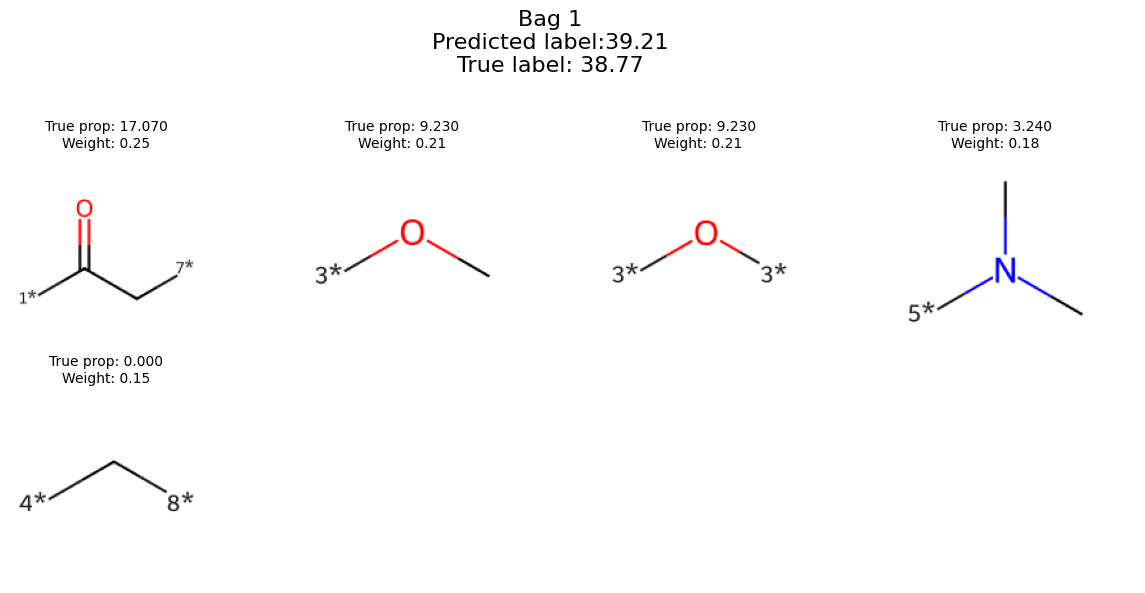

In [19]:
N = 1
display_fragments_with_weights(frg_test[N], key_test[N], w_pred[N], sort=True, max_fragments=10,
                               title=f"Bag {N}\nPredicted label:{y_pred[N].item():.2f}\nTrue label: {y_test[N]:.2f}")

### 4. Mini-benchmark

In [20]:
regressor_list = [
    
        # attention mil networks
        ("AdditiveAttentionNetworkRegressor", AdditiveAttentionNetworkRegressor()),
        ("SelfAttentionNetworkRegressor", SelfAttentionNetworkRegressor()),
        ("HopfieldAttentionNetworkRegressor", HopfieldAttentionNetworkRegressor()),

        # other mil networks
        ("DynamicPoolingNetworkRegressor", DynamicPoolingNetworkRegressor()),
    ]

In [21]:
bag_size = 5

res_df = pd.DataFrame()
tasks = ["LogP", "MolWt", "TPSA", "NumHDonors", "NumHAcceptors", 
         "MolMR", "NumRotatableBonds", "RingCount", "FractionCSP3"]

for task_idx, task in enumerate(tasks, 1):
    print(f"\n[Task {task_idx}/{len(tasks)}] Starting task: '{task}'")

    # create data
    smiles = list(pd.read_csv("data/CHEMBL1824/train.csv", header=None)[0])
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    
    bags, labels, contribs = create_fragment_bags(mols, bag_size=bag_size, property_name=task)
    dsc = compute_fragment_descriptors(bags)
    
    x_train, x_test, y_train, y_test, key_train, key_test, frg_train, frg_test = train_test_split(
        dsc, labels, contribs, bags, random_state=42)
    
    # scale features
    scaler = BagMinMaxScaler()
    scaler.fit(x_train)
    x_train_scaled, x_test_scaled = scaler.transform(x_train), scaler.transform(x_test)
    
    # build models
    for model_idx, (name, model) in enumerate(regressor_list, 1):
        print(f"  [Model {model_idx}/{len(regressor_list)}] Training model: '{name}'")

        # train model
        # model.hopt(x_train_scaled, y_train, param_grid=DEFAULT_PARAM_GRID, verbose=True)
        model.fit(x_train_scaled, y_train)
        
        # predict
        y_pred = model.predict(x_test_scaled)
        w_pred = model.get_instance_weights(x_test_scaled)
        w_pred = [w.flatten() for w in w_pred]
        #
        res_df.loc[name, f"PRED_{task}"] = r2_score(y_test, y_pred)
        res_df.loc[name, f"KID_{task}"] = kid_ranking_accuracy(key_test, w_pred)

print("\nAll tasks and models completed.")


[Task 1/9] Starting task: 'LogP'
  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
  [Model 2/4] Training model: 'SelfAttentionNetworkRegressor'
  [Model 3/4] Training model: 'HopfieldAttentionNetworkRegressor'
  [Model 4/4] Training model: 'DynamicPoolingNetworkRegressor'

[Task 2/9] Starting task: 'MolWt'
  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
  [Model 2/4] Training model: 'SelfAttentionNetworkRegressor'
  [Model 3/4] Training model: 'HopfieldAttentionNetworkRegressor'
  [Model 4/4] Training model: 'DynamicPoolingNetworkRegressor'

[Task 3/9] Starting task: 'TPSA'
  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
  [Model 2/4] Training model: 'SelfAttentionNetworkRegressor'
  [Model 3/4] Training model: 'HopfieldAttentionNetworkRegressor'
  [Model 4/4] Training model: 'DynamicPoolingNetworkRegressor'

[Task 4/9] Starting task: 'NumHDonors'
  [Model 1/4] Training model: 'AdditiveAttentionNetworkRegressor'
  [Model 2/4] Traini

In [22]:
res_df.round(2)

,PRED_LogP,KID_LogP,PRED_MolWt,KID_MolWt,PRED_TPSA,KID_TPSA,PRED_NumHDonors,KID_NumHDonors,PRED_NumHAcceptors,KID_NumHAcceptors,PRED_MolMR,KID_MolMR,PRED_NumRotatableBonds,KID_NumRotatableBonds,PRED_RingCount,KID_RingCount,PRED_FractionCSP3,KID_FractionCSP3
AdditiveAttentionNetworkRegressor,0.78,0.00,0.92,0.72,0.77,0.12,0.78,0.07,0.94,0.00,0.94,0.23,0.89,0.28,0.97,-0.19,0.99,-0.25
SelfAttentionNetworkRegressor,0.75,0.05,0.47,0.69,0.54,0.61,0.80,0.57,0.94,0.07,0.50,0.90,0.92,0.34,0.96,0.45,0.99,0.17
HopfieldAttentionNetworkRegressor,0.46,-0.06,0.47,0.79,0.51,0.51,0.58,0.55,0.56,0.26,0.50,0.91,0.84,0.34,0.90,0.13,0.36,-0.08
DynamicPoolingNetworkRegressor,0.50,0.74,0.80,0.88,0.76,0.91,0.74,0.60,0.82,0.87,0.83,0.90,0.91,0.36,0.92,0.85,0.84,0.76
